### Phase 5 : Application des techniques d’apprentissage non supervisé

In [80]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import yaml
import plotly.express as px
import os



# Load config
with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

FILE_PCA_DATA = os.path.join("..", config["paths"]["processed_data"], config["files"]["data_pca"])
FILE_MODEL = os.path.join("..", config["paths"]["models"], config["files"]["model_file"])

In [66]:
# Load PCA features
pca_features = pd.read_csv(FILE_PCA_DATA)

### Normalisation des caractéristiques

In [67]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)

### Test de modèles

#### 1. K-Means Clustering

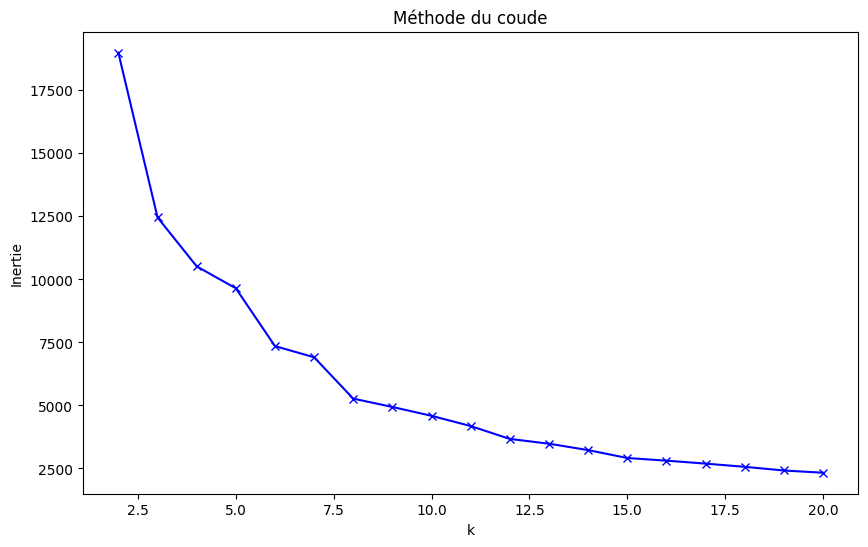

Nombre optimal de clusters : 3


In [68]:
# Remplacer l'import et le code du KElbowVisualizer par:
from sklearn.cluster import KMeans

# Fonction pour trouver le nombre optimal de clusters
def find_optimal_k(X, k_range):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Visualisation de la courbe du coude
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude')
    plt.show()
    
    # Calcul de la dérivée pour trouver le coude
    diffs = np.diff(inertias)
    optimal_k = k_range[np.argmax(np.abs(np.diff(diffs))) + 1]
    return optimal_k

# Utilisation
k_range = range(2, 21)
optimal_k = find_optimal_k(X_scaled, k_range)
print(f"Nombre optimal de clusters : {optimal_k}")

##### Visualisation K-means

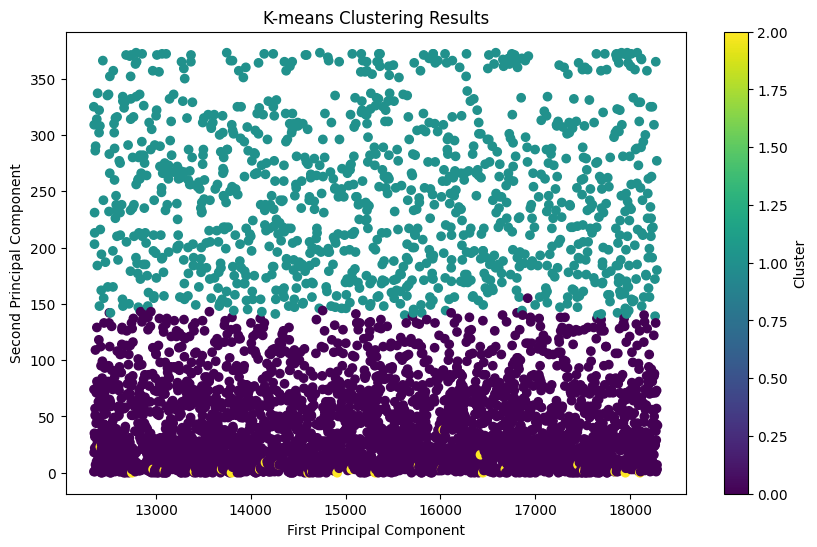

In [69]:
# Apply K-means with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualize K-means clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.show()

#### 2. DBSCAN Clustering

In [70]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

##### Visualisation DBSCAN

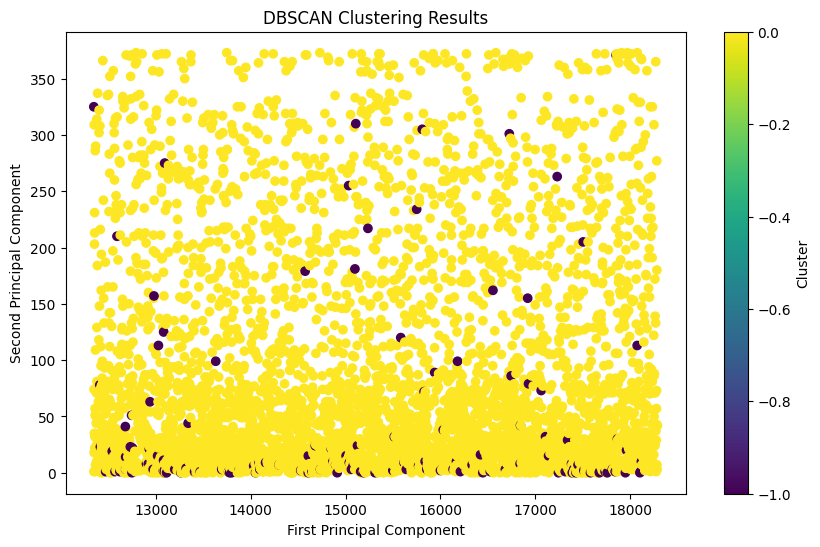

In [71]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.show()

#### 3. Clustering hiérarchique

In [72]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

##### Visualisation Cluster hiérarchique

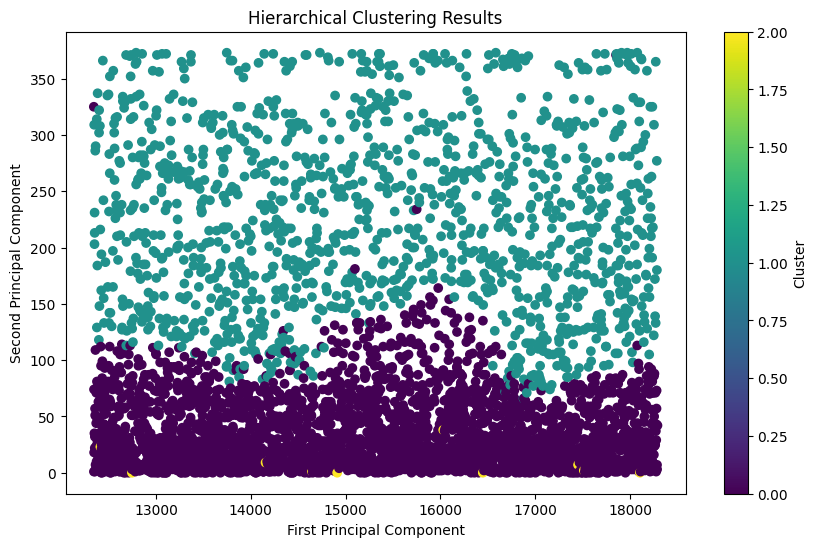

In [73]:
# Visualize Hierarchical clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.show()

### Comparaison des scores de silhouette


Silhouette Scores:
K-means: 0.460
Hierarchical: 0.404
DBSCAN: 0.647


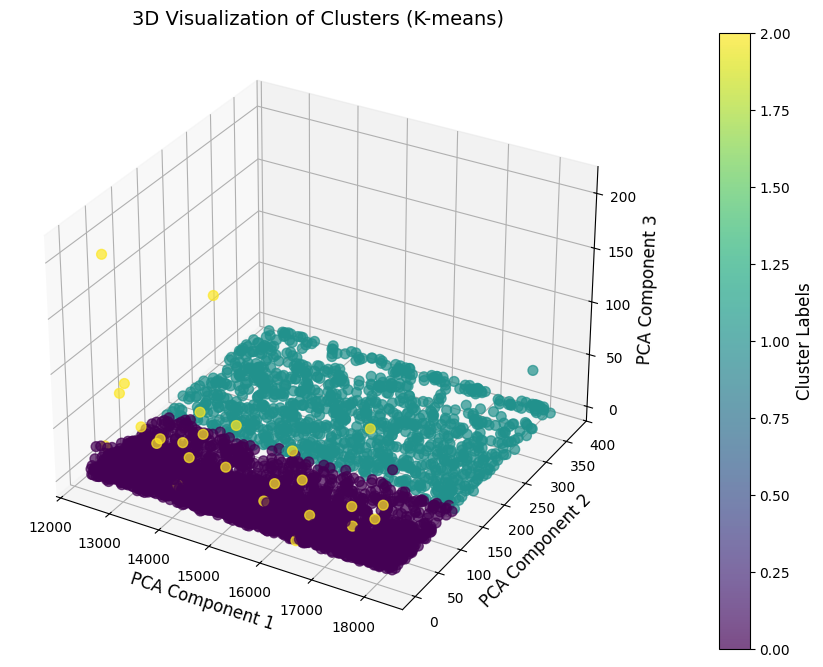

In [74]:
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Compare silhouette scores
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
silhouette_hierarchical = silhouette_score(X_scaled, hierarchical_labels)
silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else 0

print("\nSilhouette Scores:")
print(f"K-means: {silhouette_kmeans:.3f}")
print(f"Hierarchical: {silhouette_hierarchical:.3f}")
print(f"DBSCAN: {silhouette_dbscan:.3f}")

# 3D Visualization with Matplotlib
if pca_features.shape[1] >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with K-means labels
    scatter = ax.scatter(
        pca_features.iloc[:, 0],
        pca_features.iloc[:, 1],
        pca_features.iloc[:, 2],
        c=kmeans_labels,
        cmap='viridis',
        s=50,  # Point size
        alpha=0.7
    )
    
    # Set titles and labels
    ax.set_title('3D Visualization of Clusters (K-means)', fontsize=14)
    ax.set_xlabel('PCA Component 1', fontsize=12)
    ax.set_ylabel('PCA Component 2', fontsize=12)
    ax.set_zlabel('PCA Component 3', fontsize=12)
    
    # Add a color bar for the clusters
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Cluster Labels', fontsize=12)
    
    plt.show()

### Analyse des caractéristiques des clusters


Cluster Statistics:
           CustomerID                        Recency                   \
                 mean          std count        mean        std count   
Cluster                                                                 
0        15282.632931  1721.900104  3231   40.471990  35.486138  3231   
1        15355.743756  1721.718569  1081  246.243293  66.808994  1081   
2        15208.615385  1729.858609    26    5.038462   8.599911    26   

         Frequency                       Monetary                      \
              mean        std count          mean           std count   
Cluster                                                                 
0         4.665738   5.146973  3231   1845.275857   3050.902957  3231   
1         1.600370   1.505963  1081    641.669353   3025.320801  1081   
2        66.423077  49.129358    26  85826.078077  70834.064003    26   

               PC1                       PC2                  
              mean       std count    

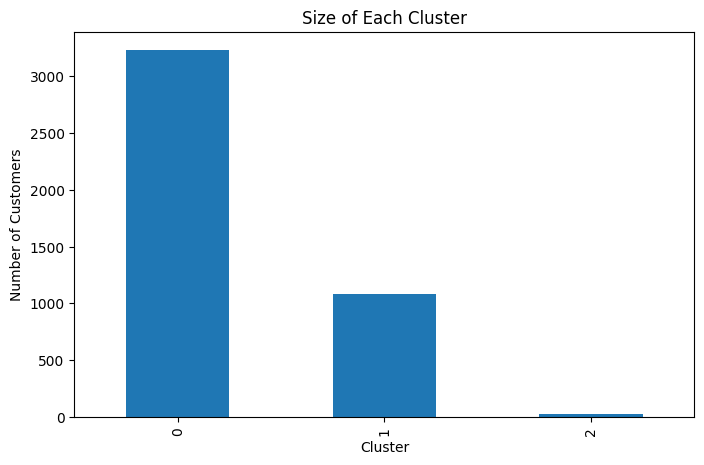

In [75]:
# Analysis of cluster characteristics
kmeans_results = pca_features.copy()
kmeans_results['Cluster'] = kmeans_labels

# Calculate cluster statistics
cluster_stats = kmeans_results.groupby('Cluster').agg(['mean', 'std', 'count'])
print("\nCluster Statistics:")
print(cluster_stats)

# Visualize cluster sizes
plt.figure(figsize=(8, 5))
cluster_sizes = kmeans_results['Cluster'].value_counts().sort_index()
cluster_sizes.plot(kind='bar')
plt.title('Size of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

In [76]:
# Final model will be k-means with 3 clusters
kmeans_final = KMeans(n_clusters=3, random_state=42)
kmeans_final.fit(pca_features)

# Get the final labels
kmeans_final_labels = kmeans_final.labels_

# Add the final labels to the dataframe
pca_features['Cluster'] = kmeans_final_labels

### Phase 6 : Interprétation des segments obtenus et proposer des actions marketing adaptées.


Analyse des segments :
           CustomerID    Recency  Frequency       Monetary        PC1  \
Cluster                                                                 
0        15301.314884  92.123023   3.894884    1433.017266  -0.078609   
1        15661.666667   5.166667  67.166667  195225.385000  19.430204   
2        15110.812500  28.906250  43.156250   48558.823125   6.919981   

              PC2  
Cluster            
0       -0.028874  
1        8.994224  
2        2.193480  


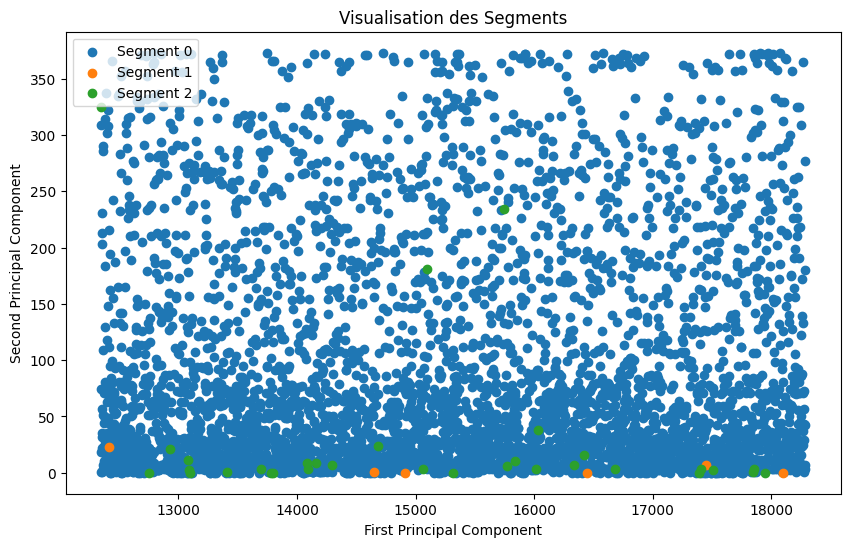


Propositions d'actions marketing :
Segment 0: Cibler les clients avec des promotions sur les produits A.
Segment 1: Proposer des offres groupées pour les clients de ce segment.
Segment 2: Mettre en place des campagnes de fidélisation pour ce groupe.


In [77]:
# Analyse des segments obtenus
segment_analysis = pca_features.groupby('Cluster').mean()
print("\nAnalyse des segments :")
print(segment_analysis)

# Visualisation des segments
plt.figure(figsize=(10, 6))
for cluster in range(3):  # Assuming 3 clusters
    plt.scatter(pca_features[pca_features['Cluster'] == cluster].iloc[:, 0],
                pca_features[pca_features['Cluster'] == cluster].iloc[:, 1],
                label=f'Segment {cluster}')
plt.title('Visualisation des Segments')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

# Propositions d'actions marketing
actions_marketing = {
    0: "Cibler les clients avec des promotions sur les produits A.",
    1: "Proposer des offres groupées pour les clients de ce segment.",
    2: "Mettre en place des campagnes de fidélisation pour ce groupe."
}

print("\nPropositions d'actions marketing :")
for cluster, action in actions_marketing.items():
    print(f"Segment {cluster}: {action}")


### Phase 7 : Export du modèle

In [81]:
# Sauvegarde du modèle de clustering avec pickle
import pickle

# Sauvegarde du modèle
with open(FILE_MODEL, 'wb') as f:
    pickle.dump(kmeans_final, f)

print(f"Le modèle de clustering a été sauvegardé avec succès à {FILE_MODEL}.")

Le modèle de clustering a été sauvegardé avec succès à ..\models/kmeans_model.pkl.
